<a href="https://colab.research.google.com/github/vishilp/dsbmed205/blob/main/PS3/ps3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import seaborn as sns
from scipy.stats import norm
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, dirichlet

In [2]:
# Load genotype matrix (5000 SNPs × 1000 individuals → Transpose to (1000, 5000))
with open("mixture1.geno", "r") as file: #split the genotypes correctly (since there's no space in between them)
    matrix = [list(line.strip()) for line in file]
orig_geno = np.array(matrix, dtype=int).T  # Shape (1000, 5000)

# Load mixture proportions (π) → Shape (2,) since K=2
orig_pi = np.loadtxt("mixture1.alpha")

# Load allele frequencies (f) → Shape (5000 SNPs, 2 populations)
orig_f = np.loadtxt("mixture1.freq")

# Load population labels (one-hot encoding: shape (1000, 2))
orig_ganc = np.loadtxt("mixture1.ganc")

with open("mixture2.geno", "r") as file: #split the genotypes correctly (since there's no space in between them)
    matrix = [list(line.strip()) for line in file]
geno2 = np.array(matrix, dtype=int).T  # Shape (1000, 5000)

In [3]:
orig_geno

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def em_algorithm(geno, seed, K, snps= 5000, max_iters=100, tol=1e-8):
    geno = geno[:,:snps]
    np.random.seed(seed)
    n, m = geno.shape  # n = 1000 individuals, m = 5000 SNPs

    # Step 1: Initialize parameters
    pi = np.random.dirichlet(np.ones(K))  # Initialize π (mixture proportions)
    f = np.random.uniform(0.1, 0.9, size=(m, K))  # Initialize f (allele frequencies)

    log_likelihoods = []  # Store log-likelihood values

    for iteration in range(max_iters):
        ### Step 2: Expectation Step (Compute Responsibilities Correctly) ###
        log_r= np.zeros((n, K))  # log of r_i,k

        for k in range(K):
          # Compute log of responsibilities to avoid numeric underflow
          log_r[:, k] = np.sum(geno * np.log(f[:, k]) + (1 - geno) * np.log(1 - f[:, k]), axis=1) + np.log(pi[k])


        # **Log-Sum-Exp Trick**
        log_probs_max = np.max(log_r, axis=1, keepdims=True)  # Get max log-prob for each row
        log_probs_shifted = log_r - log_probs_max  # Shift values to prevent underflow
        log_sums = log_probs_max + np.log(np.sum(np.exp(log_probs_shifted), axis=1, keepdims=True))  # Log-sum-exp

        # Computing inverse of log responsibilities that is also normalized
        log_responsibilities = log_r - log_sums  # Normalize
        responsibilities = np.exp(log_responsibilities)  # Convert back

        ### Step 3: Maximization Step (Update Parameters) ###
        pi = np.mean(responsibilities, axis=0)  # Update π (mixture proportions)
        f = np.dot(geno.T, responsibilities) / np.sum(responsibilities, axis=0)  # Update f (allele frequencies)

        # Prevent division by zero or log(0) issues
        f = np.clip(f, 1e-6, 1 - 1e-6)

        ### Step 4: Compute Log-Likelihood ###
        log_likelihood = np.sum(log_sums)
        log_likelihoods.append(log_likelihood)


        # Step 5: Check Convergence (Stop if log-likelihood stops improving)

        if iteration > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return pi, f, responsibilities, log_likelihoods


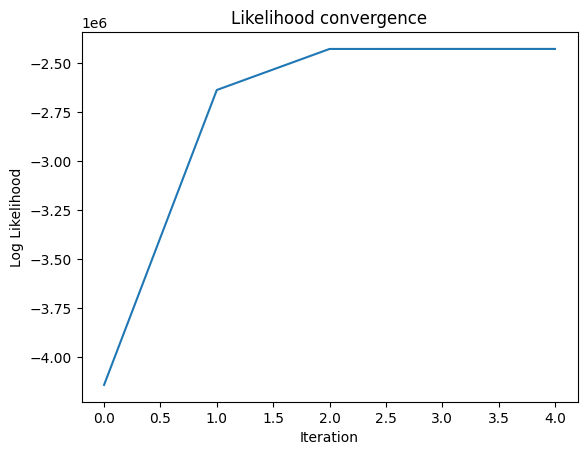

In [5]:
# Run EM algorithm
pi_mle, f_mle, r_mle, log_likelihoods = em_algorithm(orig_geno, 32, K=2)

# Plot Log-Likelihood vs Iterations
plt.plot(log_likelihoods, linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")
plt.title("Likelihood convergence")
plt.show()

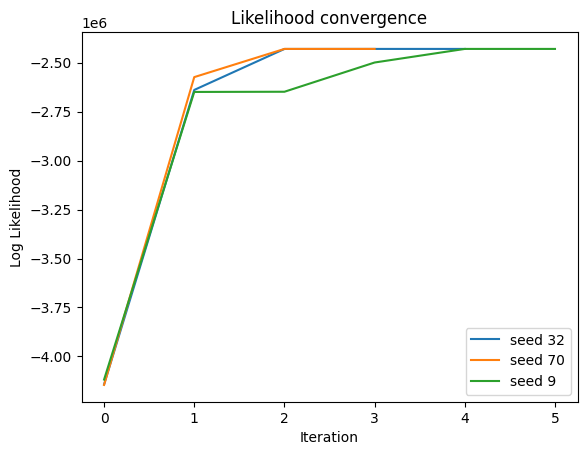

In [6]:

# Run EM algorithm
pi_mle, f_mle, r_mle, log_likelihoods = em_algorithm(orig_geno, 32, K=2)
pi_mle, f_mle, r_mle, log_likelihoods2 = em_algorithm(orig_geno, 70, K= 2)
pi_mle, f_mle, r_mle, log_likelihoods3 = em_algorithm(orig_geno, 9, K =2)

# Plot Log-Likelihood vs Iterations
plt.plot(log_likelihoods, linestyle='-')
plt.plot(log_likelihoods2, linestyle='-')
plt.plot(log_likelihoods3, linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")
plt.title("Likelihood convergence")
plt.legend(['seed 32', 'seed 70', 'seed 9'])
plt.show()

In [7]:
#2c

def compute_accuracy(r_mle, true_labels, pi_mle, f_mle, true_pi):

    inferred_labels = np.argmax(r_mle, axis=1)

    # Swap inferred labels if clusters were flipped
    if np.abs(pi_mle[0] - true_pi[1]) < np.abs(pi_mle[0] - true_pi[0]):
        inferred_labels = 1 - inferred_labels  # Flip 0 ↔ 1

    accuracy = np.mean(inferred_labels == true_labels)  # Fraction of correct classifications

    return accuracy, inferred_labels


In [8]:
#2d

# Run EM algorithm
pi_mle, f_mle, r_mle, log_likelihoods = em_algorithm(orig_geno, 17, K=2)
true_labels = np.argmax(orig_ganc, axis=1)

accuracy, inferred_labels = compute_accuracy(r_mle, true_labels, pi_mle, f_mle, orig_pi)

# Print results
print(f"Accuracy of inferred population labels: {accuracy:.4f} ({accuracy*100:.2f}%)")



Accuracy of inferred population labels: 1.0000 (100.00%)


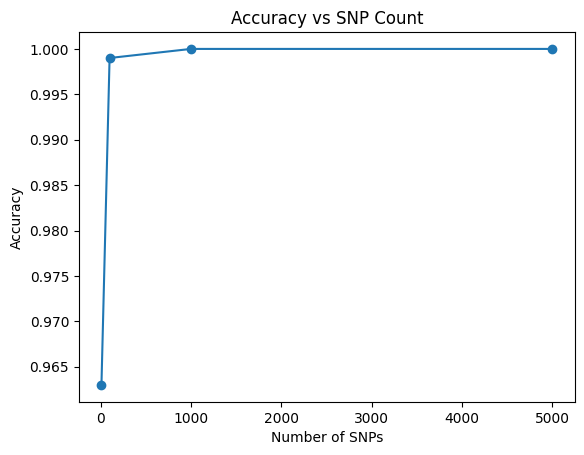

In [9]:
#2e
snps = [10, 100, 1000, 5000]
true_labels = np.argmax(orig_ganc, axis=1)
accuracies = []
for snp in snps:
    pi_mle, f_mle, r_mle, log_likelihoods = em_algorithm(orig_geno, 17, K=2, snps=snp)
    accuracy, inferred_labels = compute_accuracy(r_mle, true_labels, pi_mle, f_mle, orig_pi)
    accuracies.append(accuracy)

# Plot accuracy vs number of SNPs
plt.plot(snps, accuracies, marker='o', linestyle='-')
plt.xlabel("Number of SNPs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs SNP Count")
plt.show()

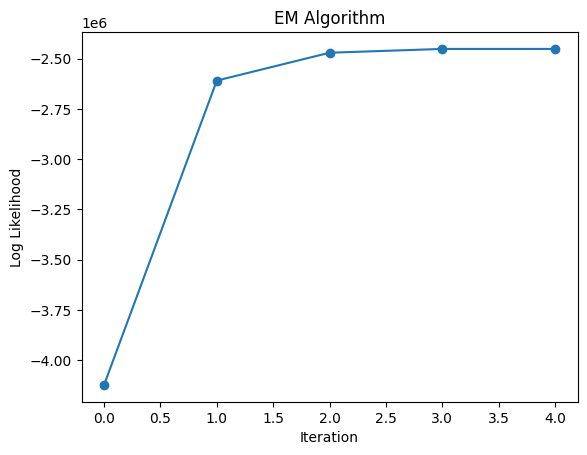

Dataset 2 MLE of pi: [0.776 0.224] 


In [10]:
#2f
pi_mle, f_mle, r_mle, log_likelihoods = em_algorithm(geno2, 9, K =2)


plt.plot(log_likelihoods, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")
plt.title("EM Algorithm")
plt.show()
print(f"Dataset 2 MLE of pi: {pi_mle} ")

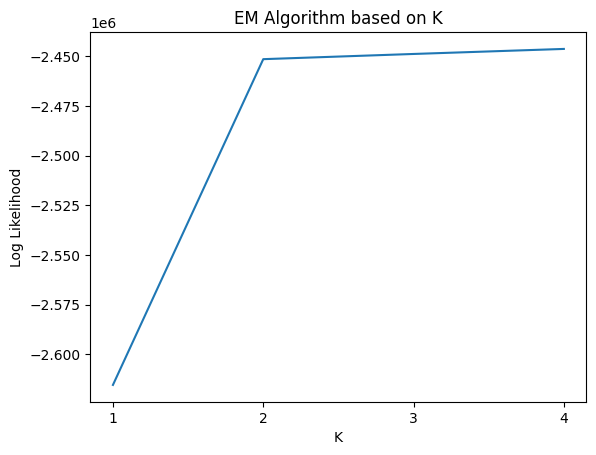

In [11]:
Ks = [1,2,3,4]
LogLikelihoods = []
for k in Ks:
    pi_mle, f_mle, r_mle, log_likelihoods = em_algorithm(geno2, 11, K =k)
    LogLikelihoods.append(log_likelihoods[-1])

plt.plot(Ks, LogLikelihoods, linestyle='-')
plt.xticks(Ks)
plt.xlabel("K")
plt.ylabel("Log Likelihood")
plt.title("EM Algorithm based on K")
plt.show()

In [12]:
#3
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd

q3data = pd.read_csv("/content/q3.data", delimiter= '\t')
q3data


,individual,population,rs189703925_T,rs11240779_A,rs186725148_G,rs113978591_G,rs1891908_T,rs61766322_G,rs77315208_C,rs187435200_A,...,rs181752170_C,rs199871809_T,rs192498220_T,rs181048877_T,rs185789787_A,rs192583248_C,rs184861241_A,rs143849140_A,rs140611932_C,rs181833046_T
0,HG00096,EUR,0,1,0,0,0,2,1,0,...,0,0,0,0,0,0,0,0,0,1
1,HG00097,EUR,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,HG00099,EUR,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HG00100,EUR,1,2,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
4,HG00101,EUR,0,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,NA20816,EUR,0,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1088,NA20818,EUR,0,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1089,NA20819,EUR,0,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1090,NA20826,EUR,0,2,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,1


In [17]:
populations = q3data.iloc[:, 1]
populations.head()

,population
0,EUR
1,EUR
2,EUR
3,EUR
4,EUR


In [18]:
snps = q3data.iloc[:, 2:].values
snps

array([[0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 2, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0]])

In [46]:
pca = PCA(n_components=2, random_state=0)
pca_result = pca.fit_transform(snps)

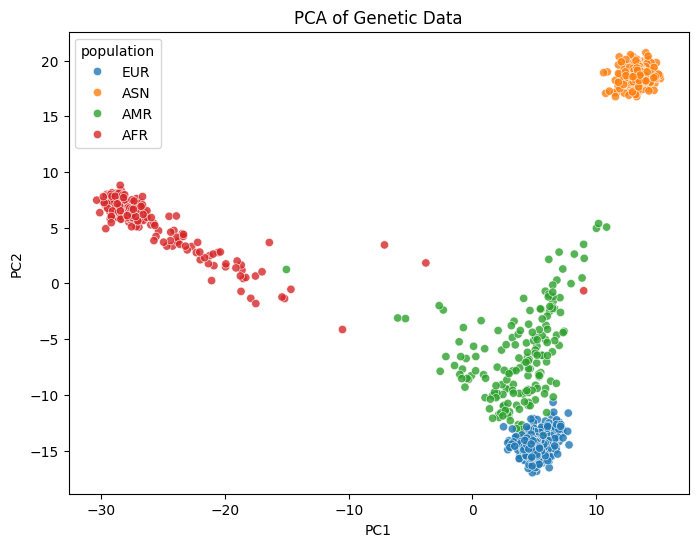

In [47]:
# Plot PCA results
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=populations, palette="tab10", alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Genetic Data")
plt.show()

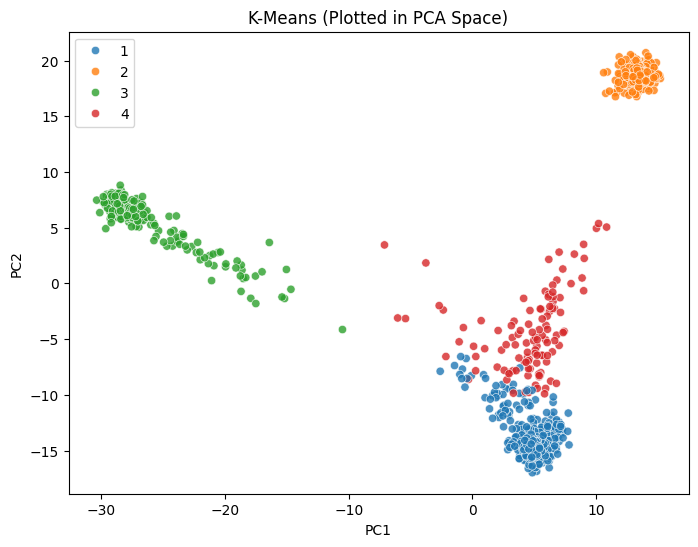

In [43]:
from sklearn.cluster import KMeans
K = 4
kmeans = KMeans(n_clusters=K, n_init=5, random_state=0)
clusters = kmeans.fit_predict(snps) #predict what cluster an individual belongs to based on snps

# Relabel clusters by size (Largest = Cluster 1)
unique, counts = np.unique(clusters, return_counts=True)
sorted_clusters = np.argsort(-counts)

#Readjust labeled clusters based on sorted clusters
cluster_mapping = {sorted_clusters[i]: i+1 for i in range(K)}
mapped_clusters = np.vectorize(cluster_mapping.get)(clusters)

# Plot PCA with Cluster Assignments
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=mapped_clusters, palette="tab10", alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means (Plotted in PCA Space)")
plt.show()


In [64]:

map = {'EUR': 1, 'ASN': 2, 'AMR': 4, 'AFR': 3} #mapping region to number

# Apply the map function to create a new column with the mapped numbers
populations_num = populations.map(map)
# Compute Accuracy of Cluster Assignment
correct_assignments = np.sum(mapped_clusters == populations_num)
accuracy = correct_assignments / len(populations)
print(f"Cluster Assignment Accuracy: {accuracy:.2%}")

Cluster Assignment Accuracy: 93.41%
